# Quantum Gradient Estimation
CDKMRippleCarryAdder. https://arxiv.org/pdf/quant-ph/0405146

In [55]:
import qiskit
import numpy as np
from matplotlib import pyplot as plt

from qiskit.circuit.library import CDKMRippleCarryAdder, DraperQFTAdder, QFT
from qiskit import QuantumCircuit, transpile, assemble, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram

Now we consider the quantum case. It suffices to show
how to perform a quantum gradient estimation at x =
0, since the gradient at other points can be obtained
by trivially redefining f . To estimate the gradient at
the origin, start with d input registers of n qubits each,
plus a single output register of no qubits, all initialized
to zero. Perform the Hadamard transform on the input
registers, write the value 1 into the output register and
then perform an inverse Fourier transform on it. This
yields the superposition

Next, use the blackbox to compute f and add it modulo No into the output register. The output register is an
eigenstate of addition modulo No. The eigenvalue corresponding to addition of x is ei2πx/No . Thus by writing
into the output register via modular addition, we obtain
a phase proportional to f . This technique is sometimes
called phase kickback. The resulting state is

Fourier transform each of the registers, obtaining

In [92]:
n, n0, d = 2, 2, 2
x0 = [0, 0]
f = lambda x : x[0]

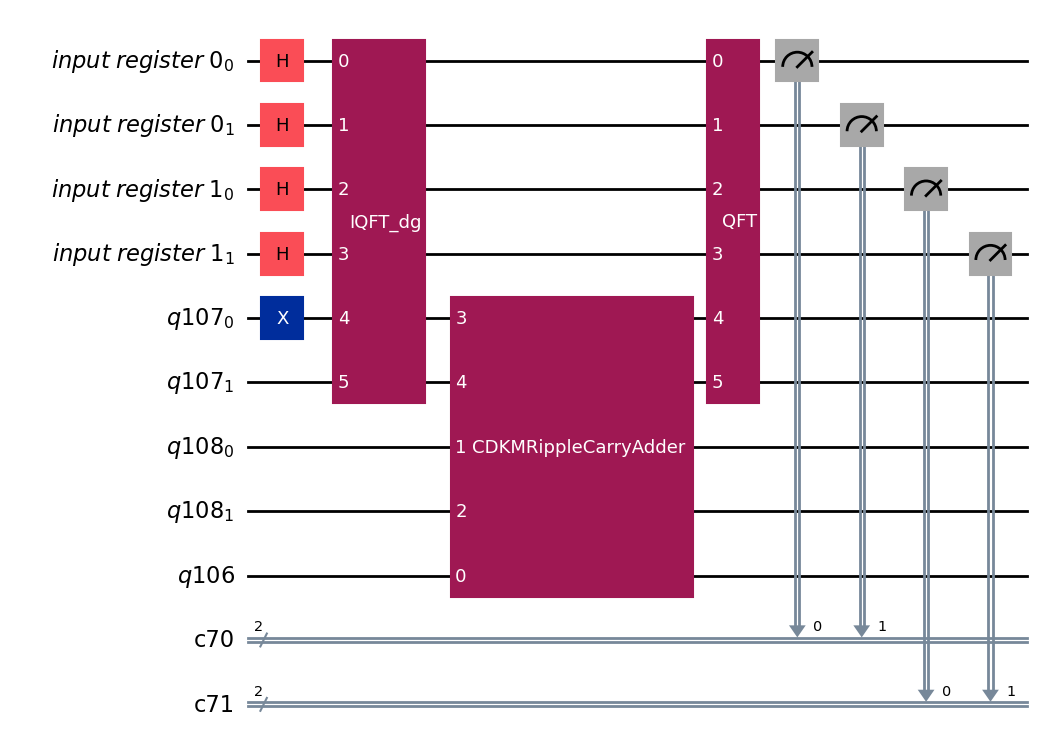

In [114]:
input_regs = []
for i in range(d):
  reg = QuantumRegister(n, 'input register ' + str(i))
  input_regs.append(reg)

carry_reg = QuantumRegister(1)
output_reg = QuantumRegister(n0)
enc_reg = QuantumRegister(n0)
cregs = [ClassicalRegister(n) for _ in range(d)]
registers = [input_regs, output_reg]

qc = QuantumCircuit(*input_regs, output_reg, enc_reg, carry_reg, *cregs)

# hadamard input
for r in input_regs:
  for q in r: 
    qc.h(q)
    
# set output to 1
qc.x(output_reg[0])

# IQFT (input + output)
qc = qc.compose(QFT(n*d+n0, inverse=True), qubits=[*[q for r in input_regs for q in r], *output_reg])

# add f(x0) into ouptut [mod 2^n0] 
v = f(x0) % (2**n0)
# v = 3
for i,c in enumerate(bin(v)[::-1][:n0]):
  if c == '1':
    qc.x(enc_reg[i])
qc = qc.compose(CDKMRippleCarryAdder(n0, kind="fixed"), qubits=[carry_reg[0], *enc_reg, *output_reg])

# qc.swap(enc_reg, input_regs[0])

# QFT
qc = qc.compose(QFT(n*d+n0))

# q
for i in range(d):
  qc.measure(input_regs[i], cregs[i]) 

qc.draw('mpl')

In [112]:
from qiskit_aer import AerSimulator, StatevectorSimulator
simulator = StatevectorSimulator()

circ = transpile(qc, simulator)
# job = execute(qc, simulator, shots=1024)
# result = job.result()

result = simulator.run(circ, shots=2**14).result()
counts = result.get_counts(circ)

In [113]:
sorted([(c, counts[c]) for c in counts], key=lambda x: -x[1])

[('01 00', 1081),
 ('00 11', 1075),
 ('10 01', 1054),
 ('01 11', 1045),
 ('00 00', 1045),
 ('11 10', 1031),
 ('10 00', 1026),
 ('11 00', 1024),
 ('10 11', 1022),
 ('00 01', 1013),
 ('10 10', 1012),
 ('01 10', 1011),
 ('11 11', 1000),
 ('01 01', 988),
 ('11 01', 979),
 ('00 10', 978)]

Result of addition: {'0001': 171, '0101': 164, '1101': 1042, '1001': 1037, '1011': 13970}


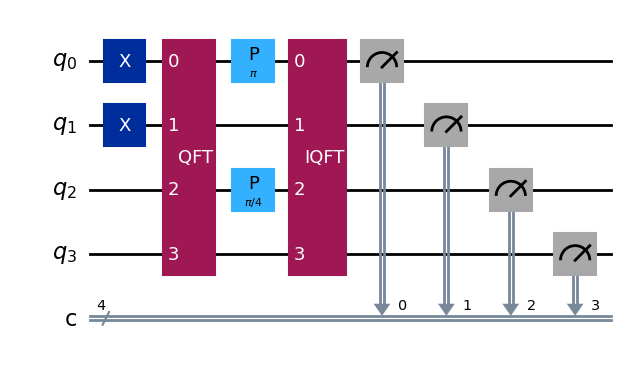

In [76]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

# Parameters
n = 4  # Number of qubits in the quantum register (defines the bit-length)
classical_value = 5  # The classical integer to add to the quantum register

# Initialize quantum and classical registers
quantum_reg = QuantumRegister(n, 'q')
classical_reg = ClassicalRegister(n, 'c')
qc = QuantumCircuit(quantum_reg, classical_reg)

# Prepare the quantum register in a known initial state, e.g., |3⟩ (binary '0011')
initial_value = 3
for i in range(n):
    if (initial_value >> i) & 1:
        qc.x(quantum_reg[i])  # Set qubit i if the corresponding bit in `initial_value` is 1

# Step 1: Apply QFT to put the quantum register in the frequency domain
qc.append(QFT(n).to_instruction(), quantum_reg)

# Step 2: Apply controlled phase rotations based on the classical value
for i in range(n):
    angle = (2 * np.pi * ((classical_value >> i) & 1)) / (2 ** (i + 1))
    if angle != 0:
        qc.p(angle, quantum_reg[i])

# Step 3: Apply the inverse QFT to complete the addition
qc.append(QFT(n, inverse=True).to_instruction(), quantum_reg)

# Measure the quantum register to get the result
qc.measure(quantum_reg, classical_reg)

# Simulate and get the results
simulator = AerSimulator()

circ = transpile(qc, simulator)
# job = execute(qc, simulator, shots=1024)
# result = job.result()

result = simulator.run(circ, shots=2**14).result()
counts = result.get_counts(circ)
print("Result of addition:", counts)

# Draw the circuit
qc.draw('mpl')